# StockPricePredictor
# XGBoost ver4

### New Features : 
### 1. added lag for predictor columns
### 2. columns are normalized


### 3. added regularization and tuning XGBoost

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from pylab import rcParams
from datetime import date
from sklearn.metrics import r2_score

In [2]:
#Functions used
def get_mape(y_true, y_pred): 
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          reg_alpha=1, \
                          reg_lambda=1):
    
    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         reg_alpha = reg_alpha,
                         reg_lambda = reg_lambda)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

In [3]:
file_path = "Yahoo.csv"

N = 3                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
reg_alpha = 1                  # L1 regularization term on weights. Increasing this value will make model more conservative. default = 1
reg_lambda = 1                 # L2 regularization term on weights. Increasing this value will make model more conservative. default = 1

model_seed = 111

In [4]:
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,AdjClose,Vol
0,0,31 Dec 2019,1.01,1.01,1.0,1.00,1.00,"592,300"
1,1,30 Dec 2019,1.01,1.01,1.0,1.01,1.01,"7,379,100"
2,2,27 Dec 2019,1.00,1.01,1.0,1.01,1.01,"564,100"
3,3,26 Dec 2019,1.01,1.01,1.0,1.00,1.00,"793,000"
4,4,24 Dec 2019,1.00,1.01,1.0,1.01,1.01,"950,000"


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 8 columns):
Unnamed: 0    1218 non-null int64
Date          1218 non-null object
Open          1218 non-null float64
High          1218 non-null float64
Low           1218 non-null float64
Close         1218 non-null float64
AdjClose      1218 non-null float64
Vol           1218 non-null object
dtypes: float64(5), int64(1), object(2)
memory usage: 76.2+ KB


In [6]:
df.describe()

,Unnamed: 0,Open,High,Low,Close,AdjClose
count,1218.000000,1218.000000,1218.000000,1218.000000,1218.000000,1218.000000
mean,608.500000,1.259404,1.269179,1.247642,1.258329,1.194038
std,351.750622,0.192239,0.192826,0.191518,0.192226,0.158539
min,0.000000,0.955000,0.960000,0.950000,0.955000,0.955000
25%,304.250000,1.090000,1.100000,1.070000,1.090000,1.053800
50%,608.500000,1.280000,1.288350,1.274150,1.275000,1.150150
75%,912.750000,1.445000,1.455000,1.433300,1.445000,1.347700
max,1217.000000,1.663300,1.663300,1.640000,1.663300,1.530800


Text(0, 0.5, 'Price')

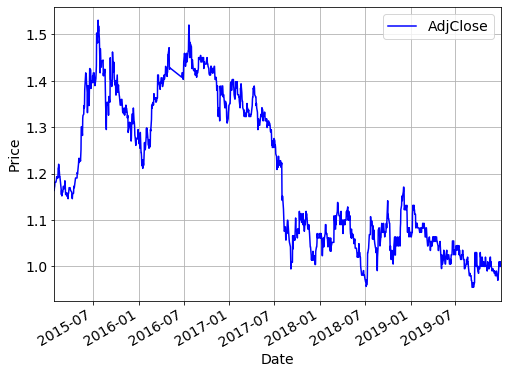

In [48]:
rcParams['figure.figsize'] = 8, 6
ax = df.plot(x='Date', y='AdjClose', style='b-', grid=True)
ax.set_xlim("27 Jan 2015", "31 Dec 2019")
ax.set_xlabel("Date")
ax.set_ylabel("Price")

In [8]:
valid_size = 0
test_size = 0
train_size = 0
for i in range(0,len(df)):
    if "2018" in df['Date'][i]:
        valid_size += 1
    elif "2019" in df['Date'][i]:
        test_size += 1
    else:
        train_size += 1


In [9]:
for i in range(0,len(df['Vol'])):
    df.loc[:,'Vol'][i] = df['Vol'][i].replace(',','')
df['Vol'] = df['Vol'].astype('int64')

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
df['Day']=df.shape[0]-df['Unnamed: 0']

In [11]:
df.sort_values(by="Day",inplace = True)
df.dropna(subset=["Date"],inplace=True)
df['Date']=pd.to_datetime(df.Date)

In [12]:
df['range_HL']=df['High']-df['Low']
df['range_OC']=df['Open']-df['Close']

In [13]:
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,AdjClose,Vol,Day,range_HL,range_OC
1217,1217,2015-01-02,1.2967,1.3067,1.2967,1.3067,1.1668,288000,1,0.0100,-0.0100
1216,1216,2015-01-05,1.3067,1.3100,1.3000,1.3100,1.1697,729000,2,0.0100,-0.0033
1215,1215,2015-01-06,1.3133,1.3133,1.2933,1.3100,1.1697,1275000,3,0.0200,0.0033
1214,1214,2015-01-07,1.3067,1.3133,1.2900,1.2900,1.1519,462000,4,0.0233,0.0167
1213,1213,2015-01-08,1.2933,1.3000,1.2767,1.2800,1.1429,1635000,5,0.0233,0.0133


In [14]:
lag_total = 3
lag_cols = ['AdjClose', 'range_HL', 'range_OC', 'Vol']

In [15]:
for lag_count in range(1,lag_total+1):
    temp = df.loc[:,['Day','AdjClose','range_HL','range_OC','Vol']]
    temp['Day'] = temp['Day'] + lag_count
    
    foo = lambda x: '{}_lag_{}'.format(x, lag_count) if x in lag_cols else x
    temp = temp.rename(columns=foo)

    df = pd.merge(df, temp, on='Day', how='left')
    df = df[lag_total:]
    
df.head()

,Unnamed: 0,Date,Open,High,Low,Close,AdjClose,Vol,Day,range_HL,...,range_OC_lag_1,Vol_lag_1,AdjClose_lag_2,range_HL_lag_2,range_OC_lag_2,Vol_lag_2,AdjClose_lag_3,range_HL_lag_3,range_OC_lag_3,Vol_lag_3
3,1208,2015-01-15,1.2833,1.2867,1.2800,1.2800,1.1429,810000,10,0.0067,...,0.0034,117000.0,1.1459,0.0133,0.0034,120000.0,1.1459,0.0133,0.0000,648000.0
4,1207,2015-01-16,1.2833,1.2833,1.2733,1.2800,1.1429,1680000,11,0.0100,...,0.0033,810000.0,1.1459,0.0100,0.0034,117000.0,1.1459,0.0133,0.0034,120000.0
5,1206,2015-01-19,1.2833,1.2867,1.2800,1.2833,1.1459,762600,12,0.0067,...,0.0033,1680000.0,1.1429,0.0067,0.0033,810000.0,1.1459,0.0100,0.0034,117000.0
6,1205,2015-01-20,1.2833,1.2933,1.2833,1.2867,1.1489,960300,13,0.0100,...,0.0000,762600.0,1.1429,0.0100,0.0033,1680000.0,1.1429,0.0067,0.0033,810000.0
7,1204,2015-01-21,1.2867,1.2900,1.2800,1.2867,1.1489,276900,14,0.0100,...,-0.0034,960300.0,1.1459,0.0067,0.0000,762600.0,1.1429,0.0100,0.0033,1680000.0


In [16]:
train_set = df[:train_size]
valid_set = df[train_size:train_size+valid_size]
test_set = df[-test_size:]

Text(0, 0.5, 'Price')

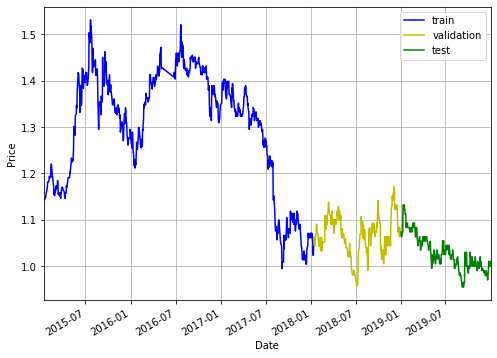

In [17]:
rcParams['figure.figsize'] = 8, 6

ax = train_set.plot(x='Date', y='AdjClose', style='b-', grid=True)
ax = valid_set.plot(x='Date', y='AdjClose', style='y-', grid=True, ax=ax)
ax = test_set.plot(x='Date', y='AdjClose', style='g-', grid=True, ax=ax)
ax.legend(['train', 'validation', 'test'])
ax.set_xlabel("Date")
ax.set_ylabel("Price")


In [18]:
#X_columns = ['range_HL','range_OC','Vol']
X_columns = []
for i in range(1,lag_total+1):
    X_columns.append('AdjClose_lag_'+str(i))
    X_columns.append('range_HL_lag_'+str(i))
    X_columns.append('range_OC_lag_'+str(i))
    X_columns.append('Vol_lag_'+str(i))
X=df.loc[:,X_columns]
y=df['AdjClose']

In [19]:
X.head()

,AdjClose_lag_1,range_HL_lag_1,range_OC_lag_1,Vol_lag_1,AdjClose_lag_2,range_HL_lag_2,range_OC_lag_2,Vol_lag_2,AdjClose_lag_3,range_HL_lag_3,range_OC_lag_3,Vol_lag_3
3,1.1459,0.0100,0.0034,117000.0,1.1459,0.0133,0.0034,120000.0,1.1459,0.0133,0.0000,648000.0
4,1.1429,0.0067,0.0033,810000.0,1.1459,0.0100,0.0034,117000.0,1.1459,0.0133,0.0034,120000.0
5,1.1429,0.0100,0.0033,1680000.0,1.1429,0.0067,0.0033,810000.0,1.1459,0.0100,0.0034,117000.0
6,1.1459,0.0067,0.0000,762600.0,1.1429,0.0100,0.0033,1680000.0,1.1429,0.0067,0.0033,810000.0
7,1.1489,0.0100,-0.0034,960300.0,1.1459,0.0067,0.0000,762600.0,1.1429,0.0100,0.0033,1680000.0


In [20]:
X_train = X[:train_size]
X_valid = X[train_size:train_size+valid_size]
X_test = X[-test_size:]
y_train = y[:train_size]
y_valid = y[train_size:train_size+valid_size]
y_test = y[-test_size:]
X_train_valid = X[:train_size+valid_size]
y_train_valid = y[:train_size+valid_size]

In [21]:
print("before")
print('mean=',np.mean(X_train,axis=0))
print('var=',np.var(X_train,axis=0))

X_train_mean = X_train.mean(axis=0)
X_train_std = np.std(X_train,axis=0)
X_train -= X_train_mean
X_train /= X_train_std
print("after")
print('mean=',np.mean(X_train,axis=0))
print('var=',np.var(X_train,axis=0))

before
mean= AdjClose_lag_1    1.295044e+00
range_HL_lag_1    2.200656e-02
range_OC_lag_1    1.535704e-03
Vol_lag_1         1.943533e+06
AdjClose_lag_2    1.295215e+00
range_HL_lag_2    2.199721e-02
range_OC_lag_2    1.540446e-03
Vol_lag_2         1.941525e+06
AdjClose_lag_3    1.295387e+00
range_HL_lag_3    2.195997e-02
range_OC_lag_3    1.498605e-03
Vol_lag_3         1.936751e+06
dtype: float64
var= AdjClose_lag_1    1.637747e-02
range_HL_lag_1    1.544736e-04
range_OC_lag_1    2.557330e-04
Vol_lag_1         2.626523e+12
AdjClose_lag_2    1.630532e-02
range_HL_lag_2    1.545736e-04
range_OC_lag_2    2.557345e-04
Vol_lag_2         2.630952e+12
AdjClose_lag_3    1.623311e-02
range_HL_lag_3    1.542257e-04
range_OC_lag_3    2.546064e-04
Vol_lag_3         2.626939e+12
dtype: float64
after
mean= AdjClose_lag_1   -3.134019e-15
range_HL_lag_1    7.394132e-16
range_OC_lag_1    5.409821e-17
Vol_lag_1        -1.529073e-16
AdjClose_lag_2   -1.425793e-15
range_HL_lag_2    4.598832e-16
range_OC_l

In [22]:
print("before")
print('mean=',np.mean(y_train,axis=0))
print('var=',np.var(y_train,axis=0))

y_train_mean = y_train.mean(axis=0)
y_train_std = np.std(y_train,axis=0)
y_train -= y_train_mean
y_train /= y_train_std
print("after")
print('mean=',np.mean(y_train,axis=0))
print('var=',np.var(y_train,axis=0))

before
mean= 1.2948994421199445
var= 0.016435588339995613
after
mean= -2.0141954120396144e-15
var= 0.9999999999999984


In [23]:
X_valid_mean = X_valid.mean(axis=0)
X_valid_std = np.std(X_valid,axis=0)
X_valid -= X_valid_mean
X_valid /= X_valid_std
y_valid_mean = y_valid.mean(axis=0)
y_valid_std = np.std(y_valid,axis=0)
y_valid -= y_valid_mean
y_valid /= y_valid_std

In [24]:
X_test_mean = X_test.mean(axis=0)
X_test_std = np.std(X_test,axis=0)
X_test -= X_test_mean
X_test /= X_test_std
y_test_mean = y_test.mean(axis=0)
y_test_std = np.std(y_test,axis=0)
y_test -= y_test_mean
y_test /= y_test_std

In [25]:
X_train_valid_mean = X_train_valid.mean(axis=0)
X_train_valid_std = np.std(X_train_valid,axis=0)
X_train_valid -= X_train_valid_mean
X_train_valid /= X_train_valid_std
y_train_valid_mean = y_train_valid.mean(axis=0)
y_train_valid_std = np.std(y_train_valid,axis=0)
y_train_valid -= y_train_valid_mean
y_train_valid /= y_train_valid_std

In [26]:
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     reg_alpha=reg_alpha,
                     reg_lambda=reg_lambda)

In [27]:
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=111, reg_alpha=1,
             reg_lambda=1, scale_pos_weight=1, seed=111, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

In [28]:
est_scaled = model.predict(X_train)
est = est_scaled*y_train_std+y_train_mean

Text(0.5, 1.0, 'With scaling')

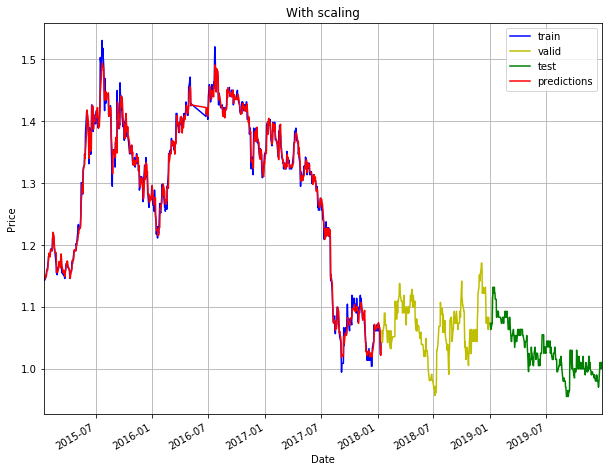

In [29]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'Date': train_set['Date']})

ax = train_set.plot(x='Date', y='AdjClose', style='b-', grid=True)
ax = valid_set.plot(x='Date', y='AdjClose', style='y-', grid=True, ax=ax)
ax = test_set.plot(x='Date', y='AdjClose', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'valid', 'test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title('With scaling')

In [30]:
y_train_original = (y_train*y_train_std+y_train_mean)
rmse_train = np.sqrt(mean_squared_error(y_train_original, est))
r2_train = r2_score(y_train_original, est)
mape_train = get_mape(y_train_original, est)
print("Goodness of Fit of Model \tTrain Dataset")
print("Explained Variance (R^2) \t:", r2_train)
print("Root Mean Squared Error (RMSE) \t:", rmse_train)
print("Mean Absolute Percentage Error (MAPE) \t:", mape_train,"%")

Goodness of Fit of Model 	Train Dataset
Explained Variance (R^2) 	: 0.9908628852569801
Root Mean Squared Error (RMSE) 	: 0.012254544321662075
Mean Absolute Percentage Error (MAPE) 	: 0.6740008138111863 %


Text(0.5, 1.0, 'With scaling')

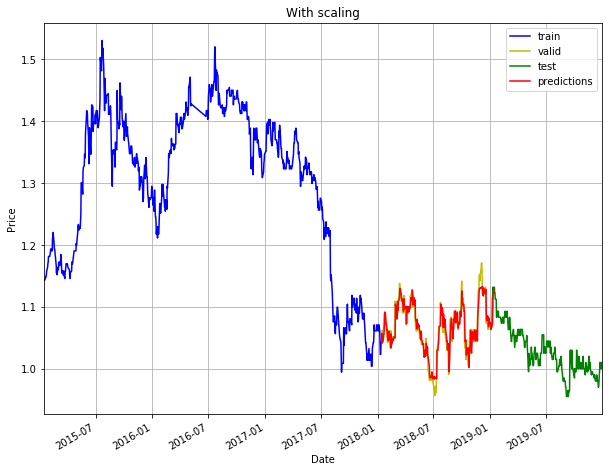

In [31]:
est_valid_scaled = model.predict(X_valid)
est_valid = est_valid_scaled*y_valid_std+y_valid_mean
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est_valid, 
                       'Date': valid_set['Date']})

ax = train_set.plot(x='Date', y='AdjClose', style='b-', grid=True)
ax = valid_set.plot(x='Date', y='AdjClose', style='y-', grid=True, ax=ax)
ax = test_set.plot(x='Date', y='AdjClose', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'valid', 'test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title('With scaling')

Text(0.5, 1.0, 'Zoom in to valid set')

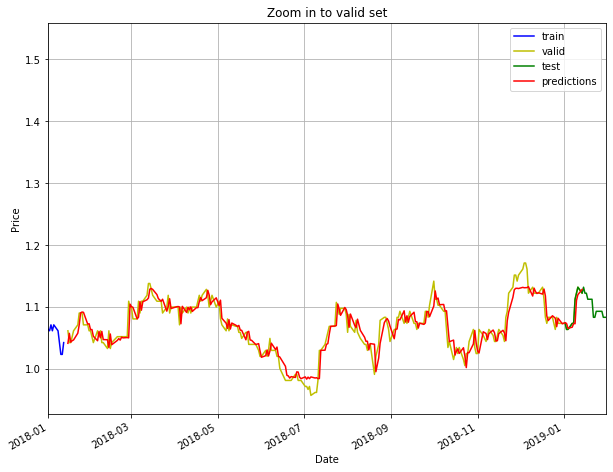

In [32]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = train_set.plot(x='Date', y='AdjClose', style='b-', grid=True)
ax = valid_set.plot(x='Date', y='AdjClose', style='y-', grid=True, ax=ax)
ax = test_set.plot(x='Date', y='AdjClose', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'valid', 'test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_xlim([date(2018, 1, 1), date(2019, 1, 31)])
ax.set_title("Zoom in to valid set")

In [33]:
y_valid_original = (y_valid*y_valid_std+y_valid_mean)
rmse_valid = np.sqrt(mean_squared_error(y_valid_original, est_valid))
r2_valid = r2_score(y_valid_original, est_valid)
mape_valid = get_mape(y_valid_original, est_valid)

print("Goodness of Fit of Model \tValid Dataset")
print("Explained Variance (R^2) \t:", r2_valid)
print("Root Mean Squared Error (RMSE) \t:", rmse_valid)
print("Mean Absolute Percentage Error (MAPE) \t:", mape_valid,"%")

Goodness of Fit of Model 	Valid Dataset
Explained Variance (R^2) 	: 0.854918475020906
Root Mean Squared Error (RMSE) 	: 0.01608600191506078
Mean Absolute Percentage Error (MAPE) 	: 1.150511234536305 %


In [34]:
# View a list of the features and their importance scores
imp = list(zip(X_train, model.feature_importances_))
imp

[('AdjClose_lag_1', 0.8641399),
 ('range_HL_lag_1', 0.0008455626),
 ('range_OC_lag_1', 0.0013153021),
 ('Vol_lag_1', 0.0007719615),
 ('AdjClose_lag_2', 0.07297779),
 ('range_HL_lag_2', 0.0009930957),
 ('range_OC_lag_2', 0.00044917993),
 ('Vol_lag_2', 0.0005504784),
 ('AdjClose_lag_3', 0.0561934),
 ('range_HL_lag_3', 0.00065048115),
 ('range_OC_lag_3', 0.00045628744),
 ('Vol_lag_3', 0.00065657764)]

Text(0.5, 1.0, 'Before tuning')

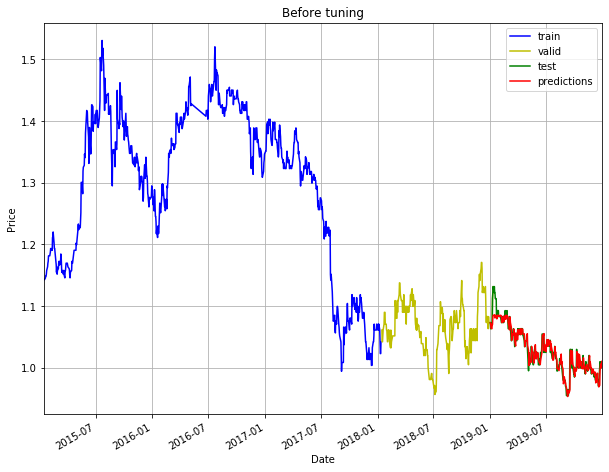

In [35]:
est_test_scaled = model.predict(X_test)
est_test = est_test_scaled*y_test_std+y_test_mean
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est_test, 
                       'Date': test_set['Date']})

ax = train_set.plot(x='Date', y='AdjClose', style='b-', grid=True)
ax = valid_set.plot(x='Date', y='AdjClose', style='y-', grid=True, ax=ax)
ax = test_set.plot(x='Date', y='AdjClose', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'valid', 'test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title('Before tuning')

In [36]:
y_test_original = (y_test*y_test_std+y_test_mean)
rmse_test = np.sqrt(mean_squared_error(y_test_original, est_test))
r2_test = r2_score(y_test_original, est_test)
mape_test = get_mape(y_test_original, est_test)
print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2_test)
print("Root Mean Squared Error (RMSE) \t:", rmse_test)
print("Mean Absolute Percentage Error (MAPE) \t:", mape_test,"%")

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.8847645062563422
Root Mean Squared Error (RMSE) 	: 0.012732054628040532
Mean Absolute Percentage Error (MAPE) 	: 0.8556790892987979 %


### Tuning model

In [37]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]


error_rate = {param_label: [], 'rmse': [], 'mape': []}
for param in param_list:
    rmse, mape, _ = train_pred_eval_model(X_train, 
                                 y_train, 
                                 X_valid, 
                                 y_valid_original, 
                                 y_valid_mean,
                                 y_valid_std,
                                 seed=model_seed,
                                 n_estimators=n_estimators, 
                                 max_depth=max_depth, 
                                 learning_rate=param, 
                                 reg_alpha = reg_alpha,
                                 reg_lambda = reg_lambda)

    # Collect results
    error_rate[param_label].append(param)
    error_rate['rmse'].append(rmse)
    error_rate['mape'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
error_rate   

,learning_rate,rmse,mape
0,0.001,0.043592,3.261607
1,0.005,0.032567,2.423614
2,0.010,0.024161,1.782951
3,0.050,0.016081,1.148248
4,0.100,0.016086,1.150511
5,0.200,0.016136,1.157726
6,0.300,0.016197,1.154145


In [38]:
learning_rate_opt = 0.05

In [39]:
param_label = 'reg_alpha'
param_list = [0.9,0.95,0.99,0.999,1]

param2_label = 'reg_lambda'
param2_list = [0.9,0.95,0.99,0.999,1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape': []}
for param in param_list:
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model

        rmse, mape, _ = train_pred_eval_model(X_train, 
                                     y_train, 
                                     X_valid, 
                                     y_valid_original, 
                                     y_valid_mean,
                                     y_valid_std,
                                     seed=model_seed,
                                     n_estimators=n_estimators, 
                                     max_depth=max_depth, 
                                     learning_rate=learning_rate_opt, 
                                     reg_alpha = param,
                                     reg_lambda = param2)

        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape'].append(mape)
    
error_rate = pd.DataFrame(error_rate)

error_rate   

,reg_alpha,reg_lambda,rmse,mape
0,0.900,0.900,0.016018,1.144013
1,0.900,0.950,0.016011,1.143125
2,0.900,0.990,0.016063,1.147336
3,0.900,0.999,0.016018,1.142067
4,0.900,1.000,0.016018,1.142069
5,0.950,0.900,0.016036,1.143813
6,0.950,0.950,0.016035,1.144947
7,0.950,0.990,0.016024,1.141161
8,0.950,0.999,0.016035,1.145049
9,0.950,1.000,0.016048,1.146879


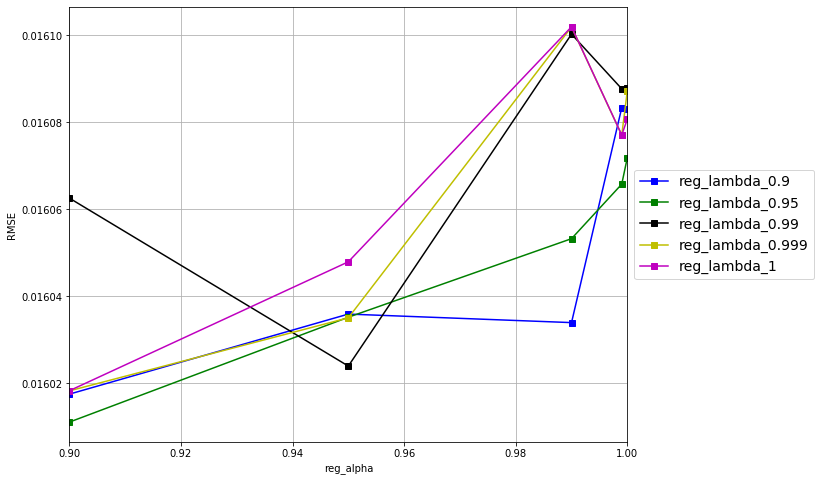

In [40]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

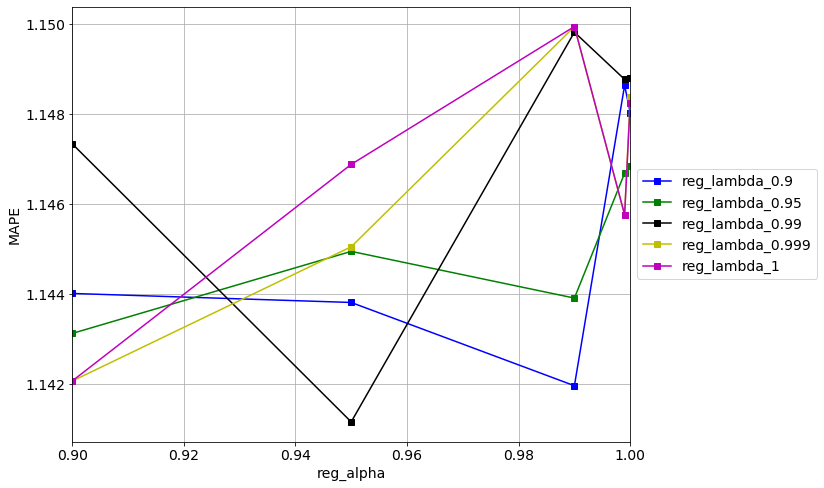

In [41]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='mape', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='mape', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("MAPE")
plt.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [42]:
reg_alpha_opt = 0.95
reg_lambda_opt = 0.99

In [43]:
model_opt = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate_opt,
                     reg_alpha=reg_alpha_opt,
                     reg_lambda=reg_lambda_opt)

In [44]:
model_opt.fit(X_train_valid,y_train_valid)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=111, reg_alpha=0.95,
             reg_lambda=0.99, scale_pos_weight=1, seed=111, subsample=1,
             tree_method=None, validate_parameters=False, verbosity=None)

Text(0.5, 1.0, 'After tuning')

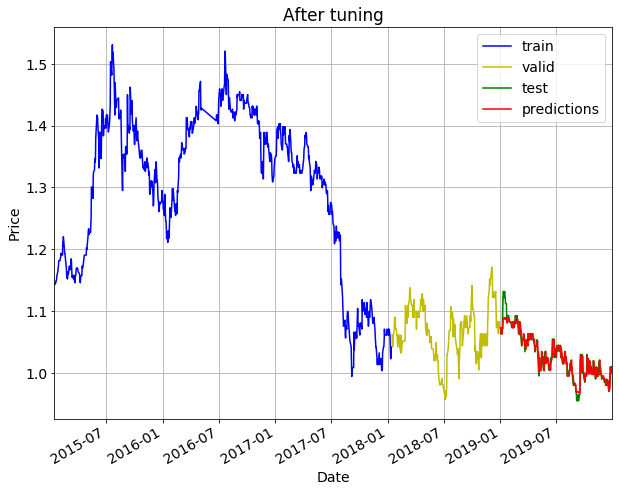

In [45]:
est_test_scaled = model_opt.predict(X_test)
est_test = est_test_scaled*y_test_std+y_test_mean
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est_test, 
                       'Date': test_set['Date']})

ax = train_set.plot(x='Date', y='AdjClose', style='b-', grid=True)
ax = valid_set.plot(x='Date', y='AdjClose', style='y-', grid=True, ax=ax)
ax = test_set.plot(x='Date', y='AdjClose', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'valid', 'test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_title('After tuning')

In [46]:
y_test_original = (y_test*y_test_std+y_test_mean)
rmse_test = np.sqrt(mean_squared_error(y_test_original, est_test))
r2_test = r2_score(y_test_original, est_test)
mape_test = get_mape(y_test_original, est_test)

print("Goodness of Fit of Model \tTest Dataset")
print("Explained Variance (R^2) \t:", r2_test)
print("Root Mean Squared Error (RMSE) \t:", rmse_test)
print("Mean Absolute Percentage Error (MAPE) \t:", mape_test,"%")

Goodness of Fit of Model 	Test Dataset
Explained Variance (R^2) 	: 0.8919550878088234
Root Mean Squared Error (RMSE) 	: 0.012328422808874714
Mean Absolute Percentage Error (MAPE) 	: 0.8446563695264933 %


Text(0.5, 1.0, 'Zoom in to test set')

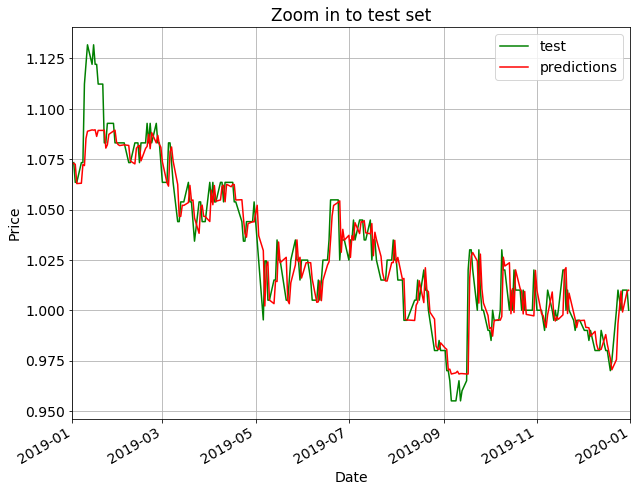

In [47]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
ax = test_set.plot(x='Date', y='AdjClose', style='g-', grid=True)
ax = est_df.plot(x='Date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['test', 'predictions'])
ax.set_xlabel("Date")
ax.set_ylabel("Price")
ax.set_xlim([date(2019, 1, 1), date(2020, 1, 1)])
ax.set_title("Zoom in to test set")